In [1]:
!nvidia-smi

Mon Aug 11 00:22:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   67C    P8             11W /   95W |     474MiB /   6144MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# import sys
# print(f"Python version: {sys.version}")

# # Install specific compatible versions to avoid conflicts
# !pip uninstall -y torch torchvision torchaudio -q
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# # Install compatible versions of other packages
# !pip install -q transformers==4.35.2
# !pip install -q diffusers==0.24.0
# !pip install -q accelerate==0.25.0
# !pip install -q safetensors==0.4.0

In [3]:
# try:
#     !pip install -q xformers
#     print("✅ XFormers installed successfully")
# except:
#     print("⚠️ XFormers installation failed, will use default attention")

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import make_image_grid
import gc
from PIL import Image
import matplotlib.pyplot as plt

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Memory optimization function
def flush():
    gc.collect()
    torch.cuda.empty_cache()

a:\Software Projects\LocalDiffusion\.venv\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
a:\Software Projects\LocalDiffusion\.venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
W0811 00:23:01.989000 8180 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
a:\Software Projects\LocalDiffusion\.venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
a:\Software Projec

Using device: cuda


In [3]:
# Use a more reliable model loading approach
model_id = "runwayml/stable-diffusion-v1-5"
print("Loading model... This may take a few minutes.")

# Load with minimal optimizations first
try:
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None,  # Disable to save memory
        requires_safety_checker=False
    )
    print("✅ Model loaded successfully!")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Trying with CPU dtype...")
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float32,
        safety_checker=None,
        requires_safety_checker=False
    )

# Move to device
pipe = pipe.to(device)

# Apply memory optimizations carefully
try:
    pipe.enable_model_cpu_offload()
    print("✅ CPU offloading enabled")
except:
    print("⚠️ CPU offloading failed, continuing without it")

# Try to enable memory efficient attention
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("✅ XFormers memory optimization enabled")
except:
    try:
        pipe.enable_attention_slicing()
        print("✅ Attention slicing enabled (fallback)")
    except:
        print("⚠️ Using default attention mechanism")

# Use faster scheduler
try:
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    print("✅ Fast scheduler enabled")
except:
    print("⚠️ Using default scheduler")

print("🎉 Setup complete! Ready to generate images.")

Loading model... This may take a few minutes.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

a:\Software Projects\LocalDiffusion\.venv\Lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


✅ Model loaded successfully!
✅ CPU offloading enabled
✅ Attention slicing enabled (fallback)
✅ Fast scheduler enabled
🎉 Setup complete! Ready to generate images.


In [11]:
def generate_image(prompt,
                  negative_prompt="blurry, bad quality, distorted, ugly",
                  num_images=1,
                  steps=15,
                  guidance_scale=10,
                  width=768,
                  height=768,
                  seed=None):
    """
    Generate images with error handling and memory management
    """

    # Set seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)

    # Clear memory before generation
    flush()

    try:
        # Generate images with proper error handling
        with torch.no_grad():  # Save memory
            if device == "cuda":
                with torch.autocast("cuda"):
                    result = pipe(
                        prompt=prompt,
                        negative_prompt=negative_prompt,
                        num_images_per_prompt=num_images,
                        num_inference_steps=steps,
                        guidance_scale=guidance_scale,
                        width=width,
                        height=height,
                        generator=torch.Generator(device=device).manual_seed(seed) if seed else None
                    )
            else:
                result = pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    num_images_per_prompt=num_images,
                    num_inference_steps=steps,
                    guidance_scale=guidance_scale,
                    width=width,
                    height=height,
                    generator=torch.Generator().manual_seed(seed) if seed else None
                )

        images = result.images

    except Exception as e:
        print(f"❌ Error during generation: {e}")
        print("Trying with reduced settings...")

        # Fallback with reduced settings
        try:
            with torch.no_grad():
                result = pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    num_images_per_prompt=1,
                    num_inference_steps=15,
                    guidance_scale=7.5,
                    width=256,
                    height=256
                )
            images = result.images
        except Exception as e2:
            print(f"❌ Fallback also failed: {e2}")
            return None

    # Clear memory after generation
    flush()

    return images


Generating: a realisitc exterior image of a large cyberpunk spaceship, pop colours, massive scale, beeple style 3D render, HD, photorealism, kitbash style


  0%|          | 0/25 [00:00<?, ?it/s]

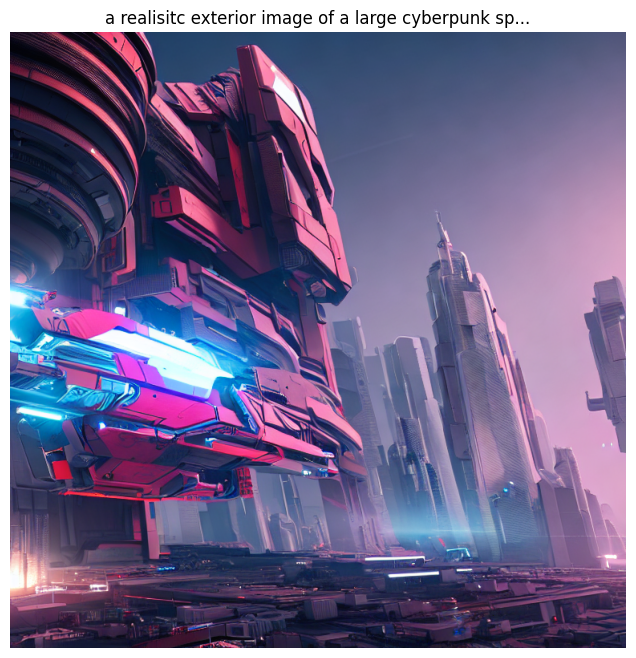

In [12]:
# Generate single image
prompt = "a realisitc exterior image of a large cyberpunk spaceship, pop colours, massive scale, 3D render, HD, photorealism, kitbash style"
print(f"Generating: {prompt}")

images = generate_image(
    prompt=prompt,
    num_images=1,
    steps=25,  # Fast generation
    seed=0    # For reproducible results
)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(images[0])
plt.axis('off')
plt.title(prompt[:50] + "...")
plt.show()